# Plotting script


In [1]:
%matplotlib inline
import pickle
import logging
import matplotlib
if __name__=='__main__':
    matplotlib.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import matplotlib.patheffects as PathEffects
import matplotlib.gridspec as gridspec
import glob
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times','Palatino']})
rc('text', usetex=True)
mpl.rcParams['xtick.major.size']=8
mpl.rcParams['ytick.major.size']=8
mpl.rcParams['xtick.labelsize']=18
mpl.rcParams['ytick.labelsize']=18

import numpy as np
import os
import scipy
from numba import jit

from classy import Class      
    
Tcmb = 2.7255 #K
rad2deg = 180./np.pi
deg2rad = np.pi / 180.
yr2sec = 356.*24.*3600.
arcsec2deg = 1/3600.
arcmin2deg = 1/60.



/Users/verag/anaconda/envs/class/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
def plot_rate(ax,cosmo,norm=None,fontsize=20,
              noplot=False,style=None,max_z_pow=7,min_z_pow=0,**kwargs):
    """
    Plot rate.

    ax    = plot axis
    cosmo = CLASS instance
    """
    z_list = np.logspace(min_z_pow,max_z_pow,50)
    rate   = np.empty_like(z_list)
    rateT  = np.empty_like(z_list)
    aH  = np.empty_like(z_list)
    
    for idx,z in enumerate(z_list):
        rate[idx],rateT[idx],aH[idx] = cosmo.dmeff_rate(z)
        

    if noplot:
        return rate
    if norm is None:
        norm = aH
    if (style is None):
        ax.loglog(z_list,rate/norm,**kwargs)
    else:
        ax.loglog(z_list,rate/norm,style,**kwargs)
    
    ax.set_xlabel(r'redshift $z$',fontsize=fontsize)
    ax.set_ylabel(r'$R_\chi/aH$',fontsize=fontsize)
    ax.set_xlim(xmin=10**min_z_pow,xmax=10**max_z_pow)
        
    return rate
    

    
def plot_temperature(ax,cosmo,mass=1.0):
    """
    Plot temperatures.

    ax    = plot axis
    cosmo = CLASS instance
    """
    z_list = np.logspace(0,13.9,50)
    T_baryon = np.empty_like(z_list)
    for idx,z in enumerate(z_list):
        T_baryon[idx] = cosmo.baryon_temperature(z)

    ax.loglog(z_list,cosmo.T_cmb()*(1.+z_list),label='CMB',color='k',ls='-')
    ax.loglog(z_list,T_baryon,label='baryon',color='b',ls='--')
    #ax.loglog(z_list, cosmo.T_cmb()/(1.+z_list[-1])*(1.+z_list)**2, color='gray',lw=1, label='adiabtic')

    T_dmeff = np.empty_like(z_list)
    for idx,z in enumerate(z_list):            
        T_dmeff[idx] = cosmo.dmeff_temperature(z)
    ax.loglog(z_list,T_dmeff,label='{}'.format(mass))

    ax.set_xlabel(r'$z$')
    ax.set_ylabel(r'$T [K]$')
    #ax.set_xlim(1.e3,1.e6)

def plot_Cl(ax,cosmo,mass=None,mode='tt',spectrum='raw',
            style=None,fontsize=20,**kwargs):
    """
    Plot C_l output from CLASS.
    
    ax  = plot axis
    cosmo = CLASS instance
    mode = 'tt', 'ee', 'te', 'bb', 'pp', or 'tp'
    spectrum = 'raw', 'lensed', 'density'
    """
    if spectrum=='lensed':
        data = cosmo.lensed_cl()
    elif spectrum=='density':
        data = cosmo.density_cl()
    else:
        data = cosmo.raw_cl()

    if mode not in data:
        print('Mode {} was not generated in spectrum calculation.'.format(mode))
        return

    lfactor = data['ell']*( data['ell']+1. ) / (2.*np.pi)*1e12*2.73**2

    if (style is None):
        ax.semilogy(data['ell'],data[mode] * lfactor,**kwargs)
    else:
        ax.semilogy(data['ell'],data[mode] * lfactor,style,**kwargs)
    ax.set_xlabel(r'$\ell$',fontsize=fontsize)
    ax.set_ylabel(r'$\ell(\ell+1)C_\ell^{{{}}}/(2\pi)$ [$\mu K^2$]'.format(mode.upper()),fontsize=fontsize)
    
    

In [5]:
def plot_cosmo(ref_cc=0.,lmax=2500,fontsize=20,mode='tt',
               masses=(1.,0.5,10.),
               ccs=(1e7,1e7,1e7),
               operators=(1,1,1),
               max_z_pow=7,min_z_pow=2.5,
               show_rate=False,
              labels=None,return_cosmo=False,save_figs=False,
              cl_file='cl.pdf',rate_file='rate.pdf'):
    
    #colors = ('#d7191c',) #tt
    #colors = ('#2c7bb6',) #ee
    colors = ('#008837','#7b3294','#c2a5cf') #masses
    #colors = ('#5e3c99','#e66101') #rates
    ###colors = ('#88419d','#8c96c6','#b3cde3')
        
    f_Cl, ax_Cl = plt.subplots()
    if show_rate:
        f_R,  ax_R  = plt.subplots()
    #f_T,  ax_T  = plt.subplots()

    cosmo = Class()
    
    par_dmeff = {}
    par_dmeff['l_max_scalars'] = lmax
    par_dmeff['omega_cdm'] = 0.12038
    par_dmeff['output'] = 'tCl pCl'
        
    par_dmeff['cc_dmeff_num'] = 1
    par_dmeff['cc_dmeff_qm2'] = 0
    par_dmeff['cc_dmeff_n'] = 0
    par_dmeff['spin_dmeff'] = 0
    par_dmeff['use_temperature_dmeff'] = 'yes'
    par_dmeff['use_helium_dmeff'] = 'no'
    par_dmeff['omega_dmeff'] = 0.12038

    for i,mass in enumerate(masses):
        cc = ccs[i]
        op = operators[i]
        color = colors[i]
        if labels is None:
            label = '{} GeV'.format(mass)
        else:
            label = labels[i]
        par_dmeff['omega_cdm'] = 0.0
        par_dmeff['m_dmeff'] = mass
        par_dmeff['cc_dmeff_p'] = cc
        par_dmeff['cc_dmeff_op'] = op
    
        cosmo.set(par_dmeff) 
        cosmo.compute()
        
        plot_Cl(ax_Cl,cosmo,label=label,color=color,fontsize=fontsize,mode=mode)

        #if (mass==1.0 and cc>0.):
        #    norm = plot_rate(ax_R,cosmo,noplot=True)
        if cc>0. and show_rate:
            plot_rate(ax_R,cosmo,label=label,color=color,max_z_pow=max_z_pow,min_z_pow=min_z_pow,fontsize=fontsize)
        
        #plot_temperature(ax_T,cosmo)
        
        cosmo.struct_cleanup()
        cosmo.empty()
        
        
    par = {}
    par['l_max_scalars'] = lmax
    par['omega_cdm'] = 0.12038
    par['output'] = 'tCl pCl'
    
    cosmo.set(par) 
    cosmo.compute()
    plot_Cl(ax_Cl,cosmo,style='--',color='k',label='no interactions',mode=mode)
        
    ax_Cl.legend(loc='lower left',frameon=False,fontsize=fontsize)
    if save_figs:
        f_Cl.savefig(cl_file,bbox_inches='tight')
    if show_rate:
        ax_R.legend(loc='lower right',frameon=False,fontsize=fontsize)
        if save_figs:
            f_R.savefig(rate_file,bbox_inches='tight')
    #ax_T.legend(loc='lower left',frameon=False)
    
    if return_cosmo:
        return cosmo
    cosmo.struct_cleanup()
    cosmo.empty()


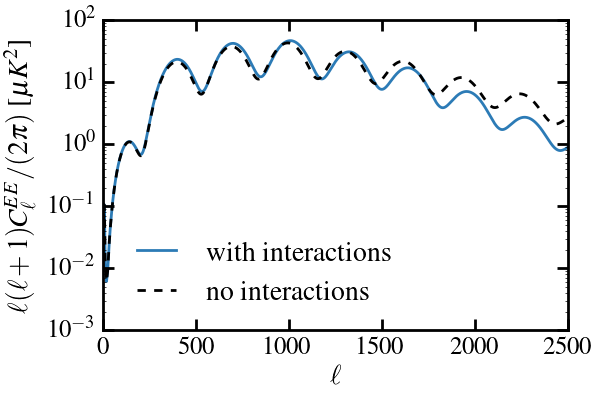

In [25]:
cosmo=plot_cosmo(masses=(1.,),operators=(1,),ccs=(1e7,),labels=('with interactions',),
                 show_rate=False,save_figs=True,return_cosmo=True,
                 cl_file='clee.pdf',rate_file='rate_ops.pdf',mode='ee',lmax=2500)

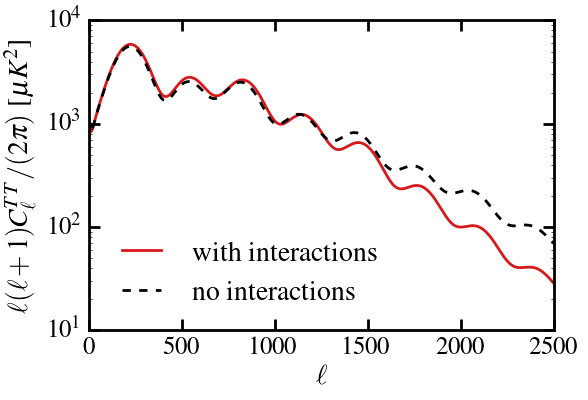

In [23]:
cosmo=plot_cosmo(masses=(1.,),operators=(1,),ccs=(1e7,),labels=('with interactions',),
                 show_rate=False,save_figs=True,return_cosmo=True,
                 cl_file='cltt.pdf',rate_file='rate_ops.pdf',mode='tt',lmax=2500)

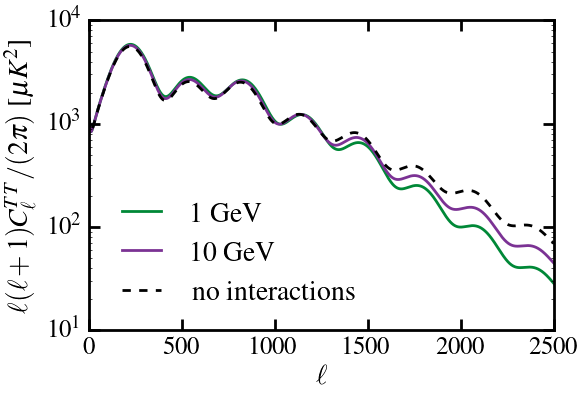

In [6]:
plot_cosmo(masses=(1.,10.),ccs=(1e7,1e7),labels=('1 GeV','10 GeV'),
                 show_rate=False,save_figs=True,operators=(1,1),
                 cl_file='cltt_ms.pdf',mode='tt',lmax=2500)

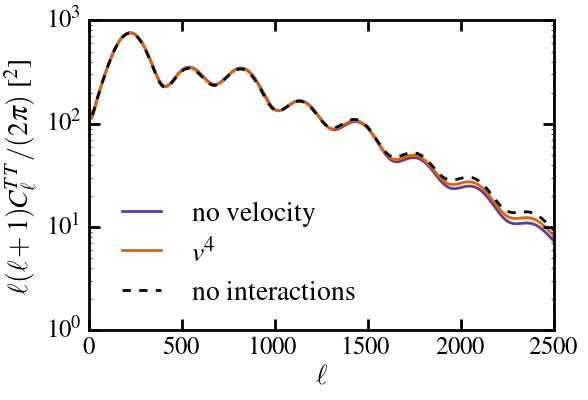

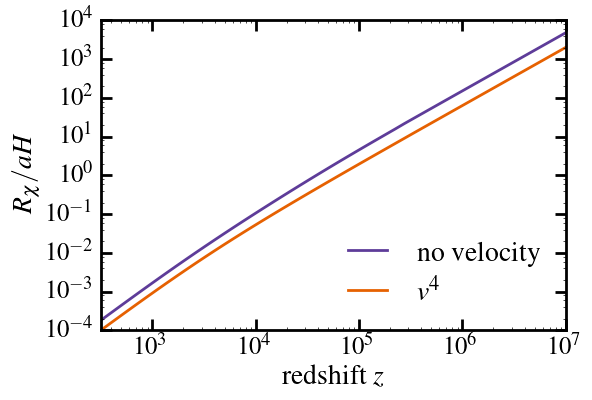

In [12]:
plot_cosmo(masses=(1.,10.,),operators=(1,1,),ccs=(5e6,5e6,),labels=(r'no velocity',r'$v^4$',),
                 show_rate=True,save_figs=False,
                 cl_file='cltt_ops.pdf',rate_file='rate_ops.pdf',mode='tt',lmax=2500)

In [112]:
def cc_ratio(m1=1.0,m2=0.001):
    ratio = (m2/m1)**(3./4.) * ((m1+1.)/(m2+1.))**(5./4.)
    return ratio
    
print 1./cc_ratio(m1=1.0,m2=0.001)

74.8609100394


In [125]:
def sigmap_ratio(m1=1.0,m2=0.001):
    ratio = (m1/m2)**0.5 * ((m1+1.)/(m2+1.))**0.5
    return ratio

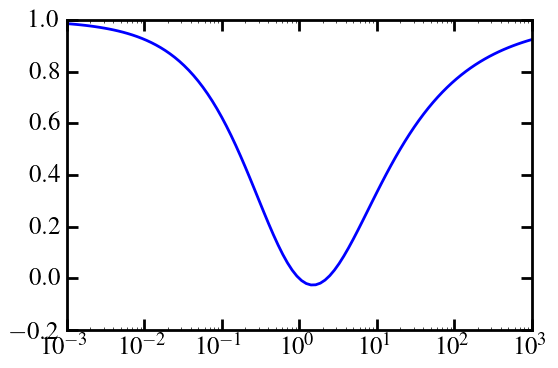

In [128]:
masses = np.logspace(-3,3,100)
ratios = np.zeros(len(masses))
for i,m in enumerate(masses):
    ratios[i] = cc_ratio(m1=1.0,m2=m)
plt.semilogx(masses, 1-ratios)

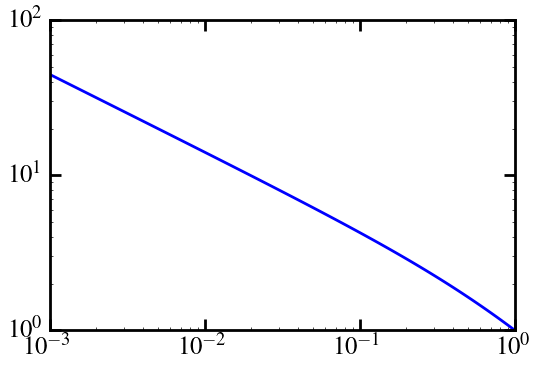

In [135]:
masses = np.logspace(-3,0,100)
ratios = np.zeros(len(masses))
for i,m in enumerate(masses):
    ratios[i] = sigmap_ratio(m1=1.0,m2=m)
plt.loglog(masses, ratios)

In [180]:
def vel_fun(v,v0=200):
    return v/np.exp(v**2/v0**2)

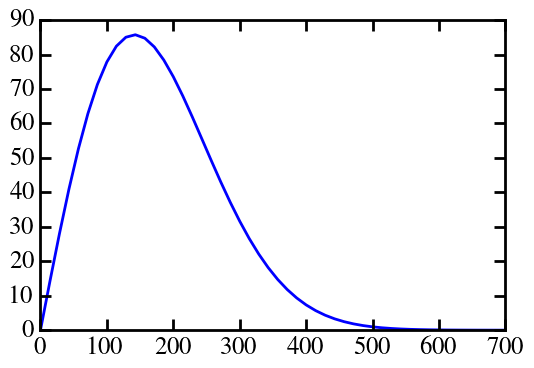

In [181]:
plt.figure()
vs = np.linspace(0,700)
fs = vel_fun(vs)
plt.plot(vs,fs)

In [ ]:
def plot_cosmo(ref_cc=0.,masses=(1.0,0.001,10.,100.),
             ccs=(1e7,1e9,1e7,1e7)):
    
    f_Cl, ax_Cl = plt.subplots()
    f_R,  ax_R  = plt.subplots()
    f_T,  ax_T  = plt.subplots()

    cosmo = Class()
    
    par_dmeff = {}
    par_dmeff['l_max_scalars'] = 5000
    par_dmeff['omega_cdm'] = 0.12038
    par_dmeff['output'] = 'tCl pCl'
        
    par_dmeff['cc_dmeff_num'] = 1
    par_dmeff['cc_dmeff_op'] = 1
    par_dmeff['cc_dmeff_qm2'] = 0
    par_dmeff['cc_dmeff_n'] = 0
    par_dmeff['spin_dmeff'] = 0
    par_dmeff['use_temperature_dmeff'] = 'yes'
    par_dmeff['use_helium_dmeff'] = 'no'
    par_dmeff['omega_dmeff'] = 0.12038

    for mass,cc in zip(masses,ccs):
        par_dmeff['omega_cdm'] = 0.0
        par_dmeff['m_dmeff'] = mass
        par_dmeff['cc_dmeff_p'] = cc
    
        cosmo.set(par_dmeff) 
        cosmo.compute()
        
        plot_Cl(ax_Cl,cosmo,mass=mass)

        if (mass==1.0 and cc>0.):
            norm = plot_rate(ax_R,cosmo,noplot=True)
        if cc>0.:
            plot_rate(ax_R,cosmo,mass=mass,norm=norm)
        plot_temperature(ax_T,cosmo,mass=mass)
        
        cosmo.struct_cleanup()
        cosmo.empty()
        
        
    par = {}
    par['l_max_scalars'] = 5000
    par['omega_cdm'] = 0.12038
    par['output'] = 'tCl pCl'
    
    cosmo.set(par) 
    cosmo.compute()
    plot_Cl(ax_Cl,cosmo,mass=0.,style=':',color='k')
    cosmo.struct_cleanup()
    cosmo.empty()
        
    ax_Cl.legend(loc=1)
    ax_R.legend(loc=1)
    ax_T.legend()

